In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

In [29]:
data = pd.read_csv("xAPI-Edu-Data.csv")

In [30]:
data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [31]:
# 데이터 기본 정보 확인
print("데이터 크기:", data.shape)
print("\n데이터 정보:")
print(data.info())
print("\n결측치 확인:")
print(data.isnull().sum())

데이터 크기: (480, 17)

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object
 14 

1. 데이터의 특성 타입:
 - 수치형(numeric) 변수: raisedhands, VisITedResources, AnnouncementsView, Discussion
 - 범주형(categorical) 변수: gender, ParentAnsweringSurvey, ParentschoolSatisfaction, StudentAbsenceDays
2. 변수의 의미적 그룹화:
 - 학생의 직접적인 학습 활동/참여도 지표: raisedhands, VisITedResources, AnnouncementsView, Discussion
 - 학부모 관련 지표: ParentAnsweringSurvey, ParentschoolSatisfaction
 - 학생의 기본 정보: gender
 - 출석 관련 지표: StudentAbsenceDays
3. 시각화 방법의 적합성:
 - 수치형 변수: 박스플롯(boxplot)을 사용하여 분포와 이상치를 한눈에 파악
 - 범주형 변수: 막대그래프(countplot)를 사용하여 각 범주별 빈도 비교

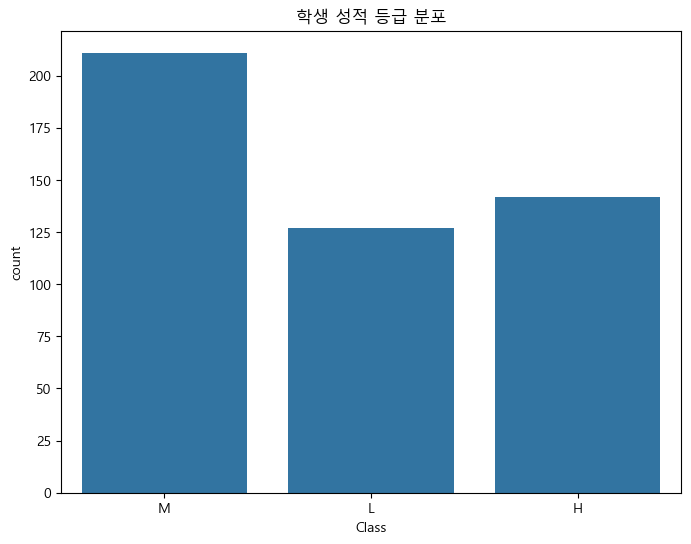

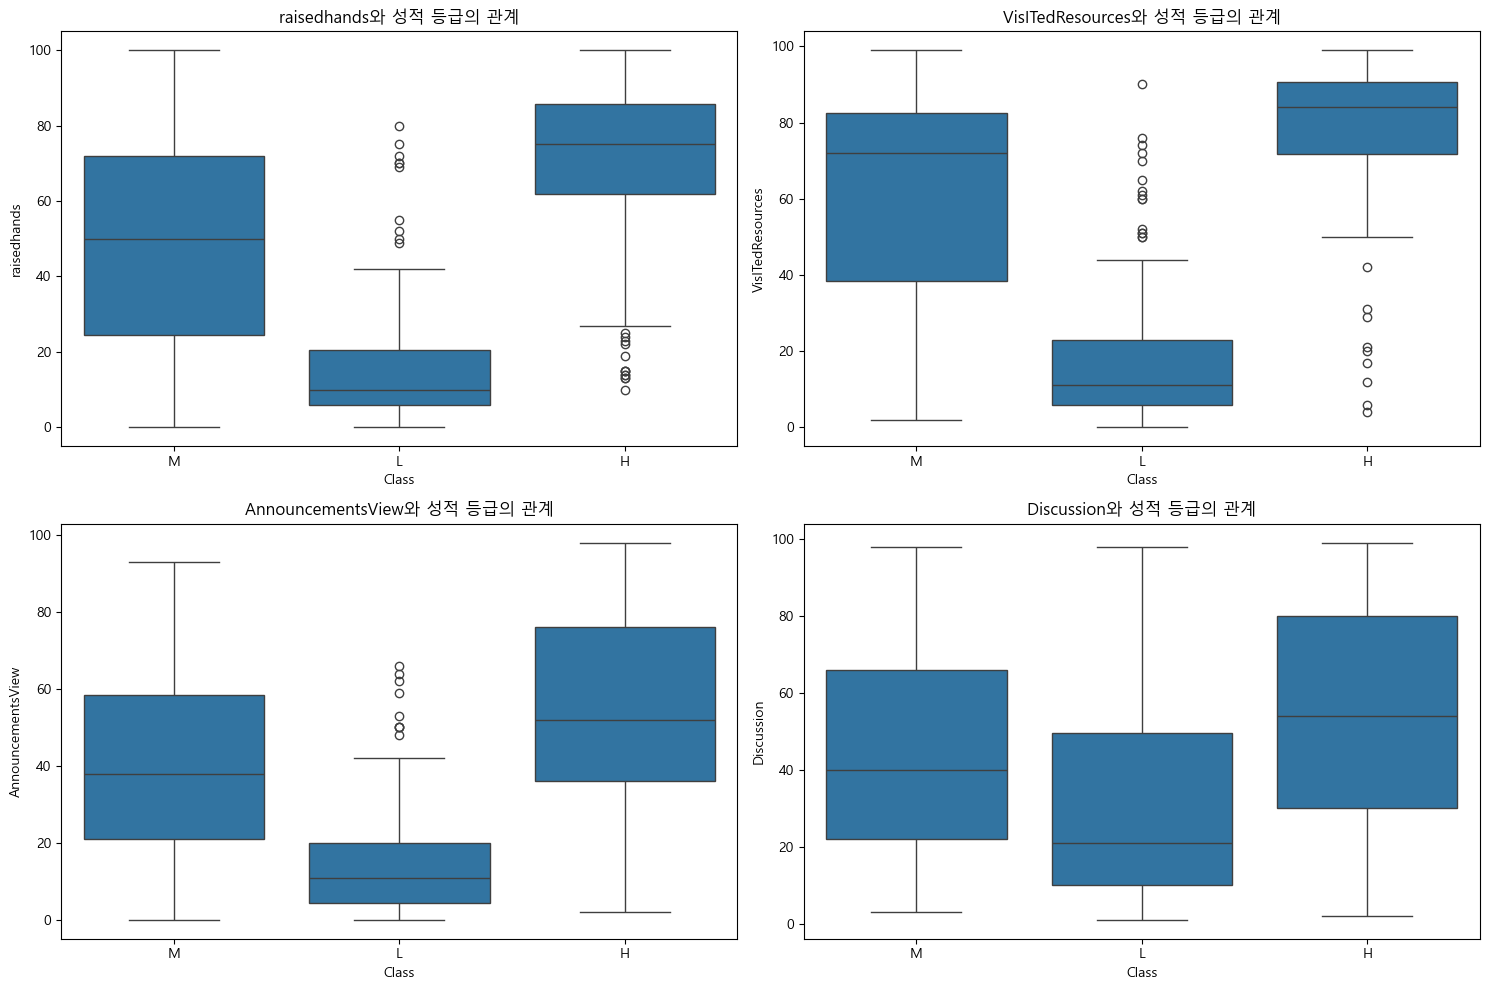

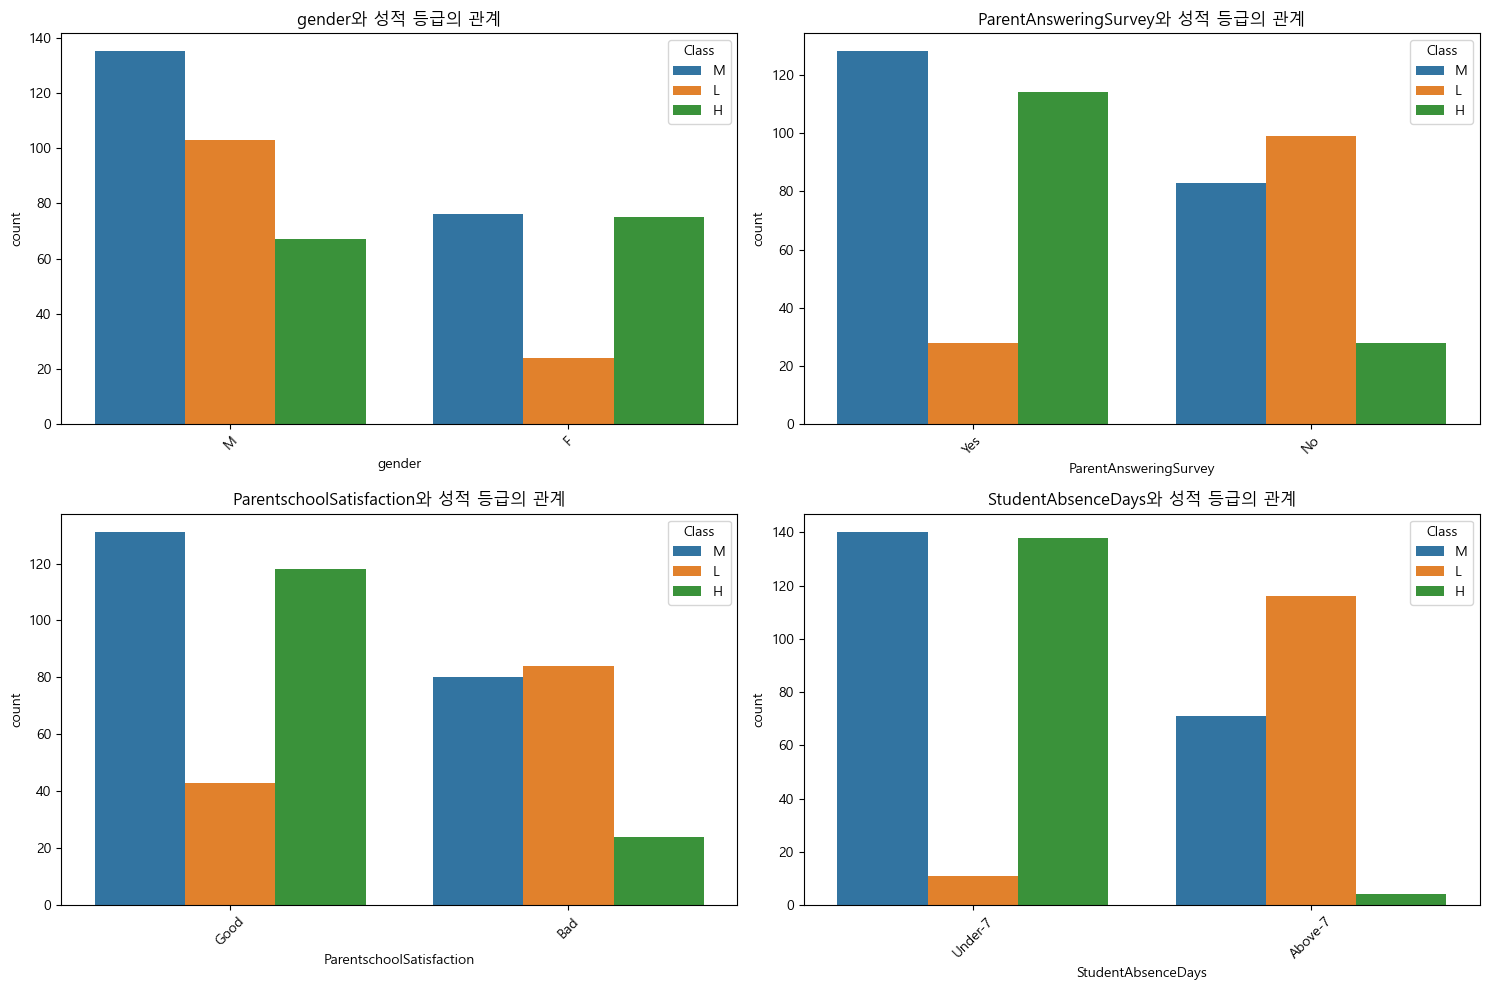

In [32]:
# 1. 성적 등급 분포 시각화
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Class')
plt.title('학생 성적 등급 분포')
plt.show()

# 2. 수치형 변수들의 분포와 성적 등급과의 관계
numeric_cols = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=data, x='Class', y=col)
    plt.title(f'{col}와 성적 등급의 관계')
plt.tight_layout()
plt.show()

# 3. 주요 범주형 변수들과 성적 등급의 관계
categorical_cols = ['gender', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=data, x=col, hue='Class')
    plt.title(f'{col}와 성적 등급의 관계')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. 수업 참여도와 성적의 관계:
 - raisedhands (수업 중 손들기): H(높은) 등급 학생들이 확연히 높은 참여도를 보입니다. 중앙값이 약 70회 정도로, L(낮은) 등급 학생들의 약 10회와 큰 차이를 보입니다.
 - VisITedResources (학습 자료 방문): 성적이 좋은 학생일수록 학습 자료 방문 횟수가 높습니다. H 등급 학생들은 대부분 60회 이상 방문했습니다.
 - Discussion (토론 참여): H 등급 학생들의 토론 참여도가 가장 높으며, L 등급 학생들은 상대적으로 낮은 참여도를 보입니다.
2. 부모 관련 요인:
 - ParentAnsweringSurvey (학부모 설문 참여): 설문에 참여한 학부모의 자녀들이 H 등급을 받은 비율이 더 높습니다.
 - ParentschoolSatisfaction (학교 만족도): 학부모의 만족도가 'Good'인 경우 자녀의 성적이 더 좋은 경향을 보입니다.
3. 출석과 성적의 관계:
 - StudentAbsenceDays: 결석이 적은(Under-7) 학생들이 높은 성적(H)을 받는 경향이 매우 뚜렷합니다.
 - Above-7(7일 이상 결석)인 학생들 중에서는 H 등급이 매우 적습니다.
4. 성별과 성적의 관계:
 - 성별에 따른 성적 분포는 상대적으로 균등한 편이나, 여학생(F)의 경우 L 등급 비율이 약간 낮은 것으로 보입니다.

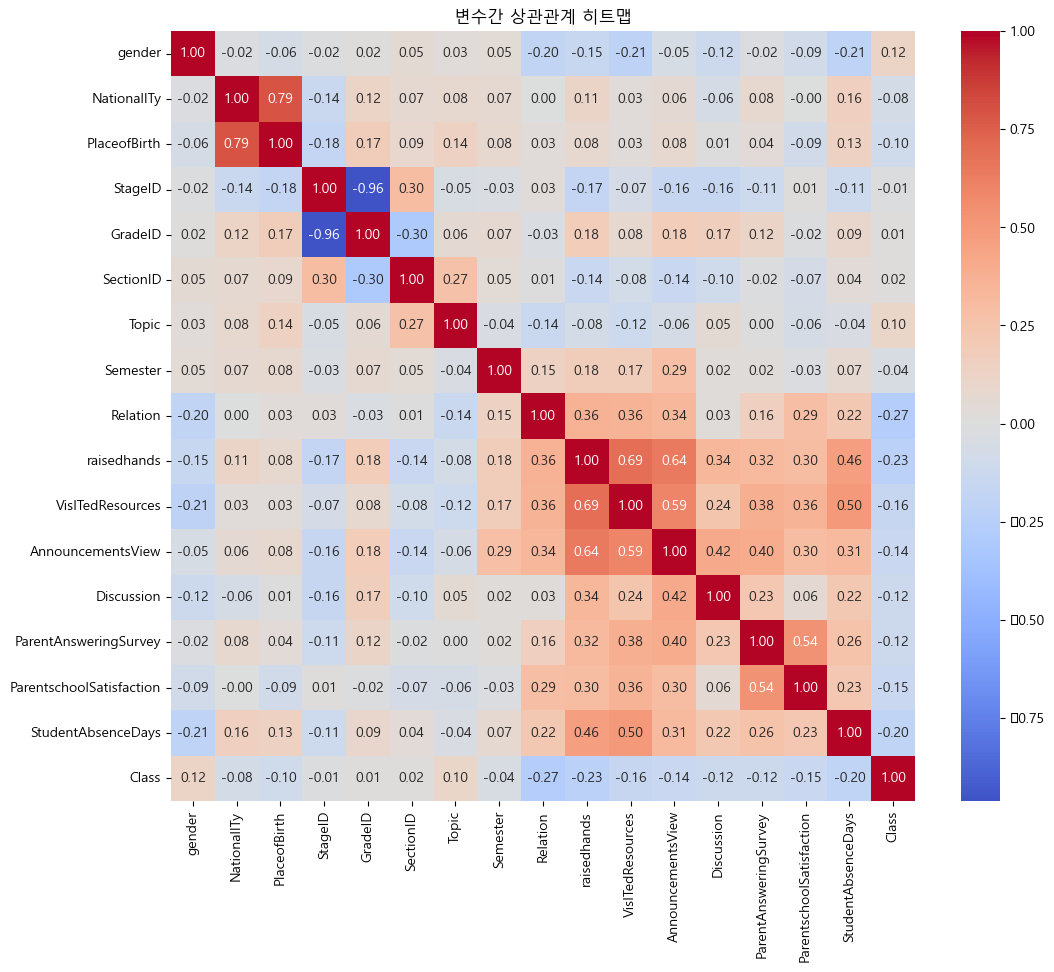


Class와의 상관관계:
Class                       1.000000
gender                      0.123675
Topic                       0.103610
SectionID                   0.017597
GradeID                     0.013483
StageID                    -0.011696
Semester                   -0.043287
NationalITy                -0.077785
PlaceofBirth               -0.098975
Discussion                 -0.121971
ParentAnsweringSurvey      -0.123254
AnnouncementsView          -0.143996
ParentschoolSatisfaction   -0.146277
VisITedResources           -0.161748
StudentAbsenceDays         -0.199083
raisedhands                -0.231016
Relation                   -0.272111
Name: Class, dtype: float64


In [33]:
# 범주형 변수 인코딩
le = LabelEncoder()
data_encoded = data.copy()
categorical_cols = ['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID', 
                   'SectionID', 'Topic', 'Semester', 'Relation', 'ParentAnsweringSurvey',
                   'ParentschoolSatisfaction', 'StudentAbsenceDays', 'Class']

for col in categorical_cols:
    data_encoded[col] = le.fit_transform(data_encoded[col])

# 상관관계 행렬 계산
plt.figure(figsize=(12, 10))
sns.heatmap(data_encoded.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('변수간 상관관계 히트맵')
plt.show()

# Class와의 상관관계만 별도로 확인
class_correlations = data_encoded.corr()['Class'].sort_values(ascending=False)
print("\nClass와의 상관관계:")
print(class_correlations)

- 다중공선성이 있는 변수들 중 하나 선택
- NationalITy와 PlaceofBirth 중 하나만 선택
- StageID와 GradeID 중 하나만 선택

- 상관관계가 매우 낮은 변수들은 제외 고려
- 예: SectionID, Semester 등

In [34]:
# PlaceofBirth 제거
data_clean = data.drop('PlaceofBirth', axis=1)

In [35]:
# 범주형 변수 전처리
# One-Hot Encoding 적용
categorical_features = ['gender', 'NationalITy', 'StageID', 'GradeID', 
                       'SectionID', 'Topic', 'Semester', 'Relation',
                       'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 
                       'StudentAbsenceDays']

# One-Hot Encoding 적용
data_encoded = pd.get_dummies(data_clean, columns=categorical_features)

In [36]:
# 수치형 변수 스케일링
# 수치형 변수들에 대한 스케일링
numeric_features = ['raisedhands', 'VisITedResources', 
                   'AnnouncementsView', 'Discussion']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_encoded[numeric_features] = scaler.fit_transform(data_encoded[numeric_features])

In [37]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   raisedhands                    480 non-null    float64
 1   VisITedResources               480 non-null    float64
 2   AnnouncementsView              480 non-null    float64
 3   Discussion                     480 non-null    float64
 4   Class                          480 non-null    object 
 5   gender_F                       480 non-null    bool   
 6   gender_M                       480 non-null    bool   
 7   NationalITy_Egypt              480 non-null    bool   
 8   NationalITy_Iran               480 non-null    bool   
 9   NationalITy_Iraq               480 non-null    bool   
 10  NationalITy_Jordan             480 non-null    bool   
 11  NationalITy_KW                 480 non-null    bool   
 12  NationalITy_Lybia              480 non-null    boo

In [38]:
# 목표 변수 인코딩
# Class 변수 Label Encoding
le = LabelEncoder()
y = le.fit_transform(data['Class'])

로지스틱 회귀 모델 성능:
정확도: 0.7916666666666666

분류 보고서:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74        22
           1       0.79      0.88      0.84        26
           2       0.80      0.77      0.79        48

    accuracy                           0.79        96
   macro avg       0.79      0.79      0.79        96
weighted avg       0.79      0.79      0.79        96


XGBoost 모델 성능:
정확도: 0.8541666666666666

분류 보고서:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        22
           1       0.83      0.92      0.87        26
           2       0.87      0.83      0.85        48

    accuracy                           0.85        96
   macro avg       0.85      0.86      0.85        96
weighted avg       0.86      0.85      0.85        96



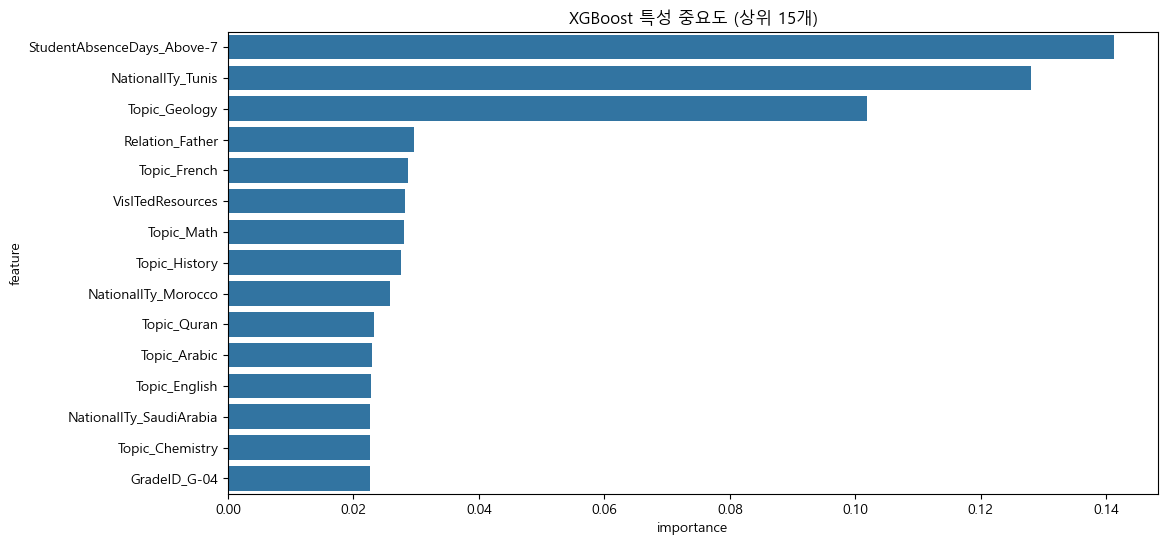

In [39]:
# 데이터 분할
X = data_encoded.drop('Class', axis=1)
y = le.fit_transform(data['Class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Logistic Regression 성능 평가
lr_pred = lr_model.predict(X_test)
print("로지스틱 회귀 모델 성능:")
print("정확도:", accuracy_score(y_test, lr_pred))
print("\n분류 보고서:")
print(classification_report(y_test, lr_pred))

# 2. XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# XGBoost 성능 평가
xgb_pred = xgb_model.predict(X_test)
print("\nXGBoost 모델 성능:")
print("정확도:", accuracy_score(y_test, xgb_pred))
print("\n분류 보고서:")
print(classification_report(y_test, xgb_pred))

# 특성 중요도 시각화 (XGBoost)
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('XGBoost 특성 중요도 (상위 15개)')
plt.show()

In [40]:
from sklearn.model_selection import GridSearchCV

# XGBoost 하이퍼파라미터 튜닝
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("최적 파라미터:", grid_search.best_params_)
print("최고 정확도:", grid_search.best_score_)

최적 파라미터: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
최고 정확도: 0.7760423786739576


In [41]:
from sklearn.model_selection import cross_val_score

# 5-fold 교차 검증
cv_scores = cross_val_score(xgb_model, X, y, cv=5)
print("교차 검증 정확도: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

교차 검증 정확도: 0.67 (+/- 0.05)


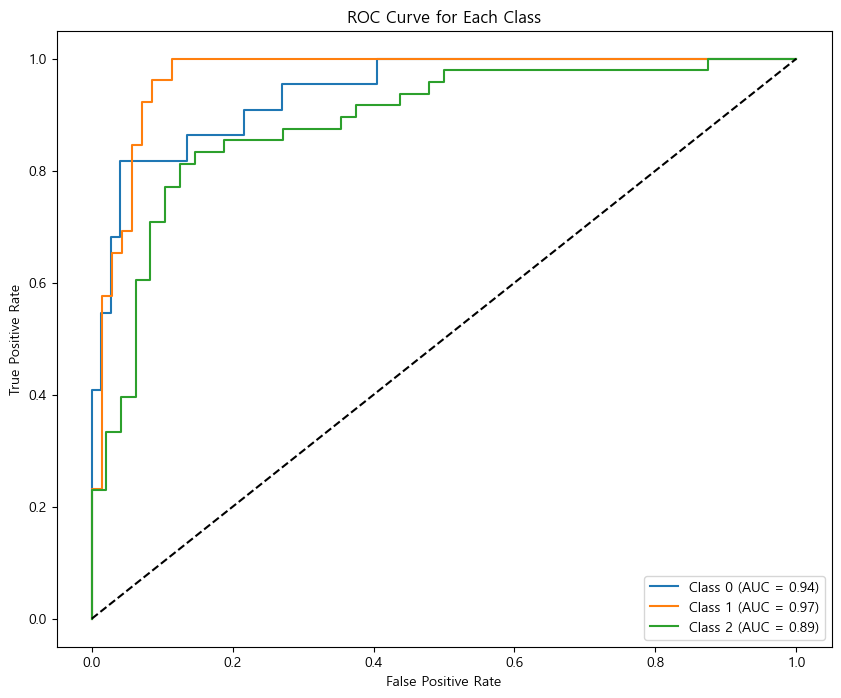

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# 다중 클래스를 위한 ROC 커브
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_proba = xgb_model.predict_proba(X_test)

plt.figure(figsize=(10, 8))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

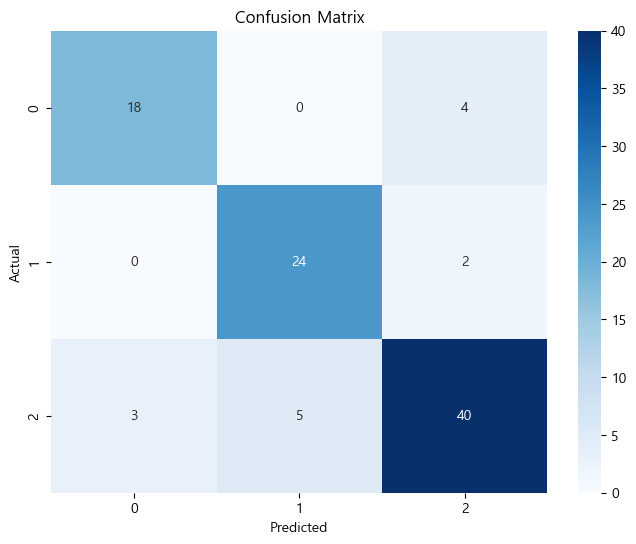

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()